In [36]:
"""
GP-limit continual learning theory for two-way classification problems.
1. EVERY RANDOM SEED CORRESPONDS TO A NEW RANDOM DATA SAMPLE!!!

"""

%load_ext autoreload
%autoreload 2

# only save loss/accuracy of the first task across time
# this is to reduce the size of the output file
ONLY_FIRST_TASK = False


import numpy as np
import theory, cluster_utils, data, torch, sys

ON_CLUSTER, data_path, output_home_path = cluster_utils.initialize()

parser = cluster_utils.Args()
parser.add('P', 10)  # size of each training set
parser.add('P_test', 200)  # size of each testing set
parser.add('n_tasks', 2, help='number of tasks in the sequence')
parser.add('T', 0.0, help='temperature')
parser.add('sigma', 0.2, help='weight variance')
parser.add('permutation', 1.0,
           help='permutation strength; 1.0=full permulation')
parser.add('resample', 0, help='boolean variable')
parser.add('depth', 1,
           help='num of hidden layers.'
           'setting depth=0 would use the input kernel')
parser.add('seed', 0, help='random seed')
parser.add('lambda_val', 1e5, help='lambda')
parser.add('use_large_lambda_limit', 1,
            help='whether to assume infinite lambda.'
           'this makes calculations substantially faster.')
parser.add('task_type', 'split', help='permuted/split')
parser.add('naive_gp', 0, help='1/0')
parser.add('dataset', 'mnist', help='mnist/cifar/fashion/cifar100')
parser.add('N0context', 0, help='embedding dimension')
parser.add('context_strength', 1.0,
            help='magnifying factor for context embedding')
parser.add('save_outputs', 0, help='1/0'
           '; decides whether or not to save predictions on datasets;'
           ' takes up a lot of disk space')
parser.add('whiten', 0, help='1/0. Whether to whiten data first.')
args = parser.parse_args()

# log whether only saving first task performance
args.only_first_task = ONLY_FIRST_TASK

run_name = f'{args.BATCH_NAME}_{args.TRIAL_IND}'

logger = cluster_utils.Logger(
    output_path=f'{output_home_path}{args.BATCH_NAME}/',
    run_name=run_name,
    only_print=not ON_CLUSTER)

logger.log(str(args))
results = {'args': args}

# Use the same seed for sampling the dataset etc.
torch.manual_seed(args.seed)
args.data_seed = args.seed


seq_of_train_x, seq_of_test_x, seq_of_train_y, seq_of_test_y = \
    data.prepare_split_sequence(
        args.P,
        args.P_test,
        dataset_name=args.dataset,
        data_path=data_path,
        precision=64,
        n_tasks=args.n_tasks,
        split_ratio=0.2,
        whitening=args.whiten,)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
06/24/2024 13:42:53 | Name of this run: BATCH_NAME_0
06/24/2024 13:42:53 | Namespace(f=None, cluster=0, BATCH_NAME='BATCH_NAME', TRIAL_IND=0, P=10, P_test=200, n_tasks=2, T=0.0, sigma=0.2, permutation=1.0, resample=0, depth=1, seed=0, lambda_val=100000.0, use_large_lambda_limit=1, task_type='split', naive_gp=0, dataset='mnist', N0context=0, context_strength=1.0, save_outputs=0, whiten=0, only_first_task=False)
torch.Size([4, 784])
torch.Size([1, 784])
torch.Size([4, 784])
torch.Size([1, 784])
torch.Size([80, 784])
torch.Size([20, 784])
torch.Size([80, 784])
torch.Size([20, 784])


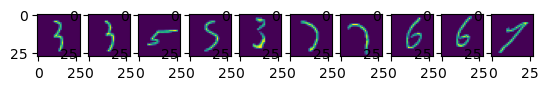

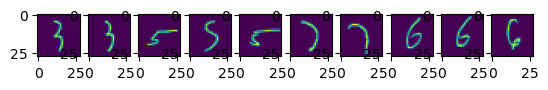

In [40]:
import matplotlib.pyplot as plt


_, axes = plt.subplots(ncols=10, nrows=1)
axes = axes.ravel()
for i in range(args.P):
    plt.sca(axes[i])
    plt.imshow(seq_of_train_x[0][i].reshape(28, 28))

_, axes = plt.subplots(ncols=10, nrows=1)
axes = axes.ravel()
for i in range(args.P):
    plt.sca(axes[i])
    plt.imshow(seq_of_train_x[1][i].reshape(28, 28))

In [8]:
import matplotlib.pyplot as plt
split_ratio = 0.8


assert 0 <= split_ratio <= 1

P_digit_share = int(args.P * (1 - split_ratio) / (args.n_tasks) / 2)
p_per_class = int(args.P / 2)

# reshape into T x n_digits_per_task(2) x Pd x N0
reshaped_seq_train_x = seq_of_train_x.reshape(args.n_tasks, 2, int(args.P/2), -1)
returned_seq_train_x = torch.zeros_like(reshaped_seq_train_x)

# all shared x for class 1
shared_class1_tr_x = torch.vstack([
    reshaped_seq_train_x[
        i, 0, :P_digit_share] for i in range(args.n_tasks)])

shared_class2_tr_x = torch.vstack([
    reshaped_seq_train_x[
        i, 1, :P_digit_share] for i in range(args.n_tasks)])

p_shared_per_class = shared_class1_tr_x.shape[0]

P_digit_unshared = p_per_class - p_shared_per_class

for i in range(args.n_tasks):
    # all unshared x for class 1
    unshared_class1_tr_x = reshaped_seq_train_x[
        i, 0, P_digit_share:(P_digit_share+P_digit_unshared)]
    unshared_class2_tr_x = reshaped_seq_train_x[
        i, 1, P_digit_share:(P_digit_share+P_digit_unshared)]

    returned_seq_train_x[i, 0] = torch.vstack([shared_class1_tr_x, unshared_class1_tr_x])
    returned_seq_train_x[i, 1] = torch.vstack([shared_class2_tr_x, unshared_class2_tr_x])


In [9]:
returned_seq_train_x.shape

torch.Size([10, 2, 250, 784])